In [1]:
# This notebook is based on the findings and work of Peirre M

### Introduction 

The core assumption of Word2Vec is that if two words are used in similar contexts, then they should share a similar meaning and vector representation.We’re making an assumption that the meaning of a word can be inferred by the company it keeps. This is analogous to the saying, “show me your friends, and I’ll tell who you are”.

If you have two words that have very similar neighbors (meaning: the context in which it’s used is about the same), then these words are probably quite similar in meaning or are at least related. For example, the words shocked, appalled and astonished are usually used in a similar context.

These vector representations can then be used in clustering a set of documents or in text classification tasks. The core idea of Word2vec arises from the two base papers

`1. Efficient Estimation of Word Representations in Vector Space`
>(https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

`2. Distributed Representations of Words and Phrases and their Compositionality`
>(https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)


From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

In training a Word2Vec model, there can actually be different ways to represent the neighboring words to predict a target word. In the original Word2Vec article, 2 different architectures were introduced. One known as **CBOW** for continuous bag-of-words and the other called **SKIPGRAM**.

The **CBOW model** learns to predict a target word leveraging all words in its neighborhood. The sum of the context vectors are used to predict the target word. The neighboring words taken into consideration is determined by a pre-defined window size surrounding the target word.

The **SkipGram model** on the other hand, learns to predict a word based on a neighboring word. To put it simply, given a word, it learns to predict another word in it’s context.

In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models.phrases import Phrases, Phraser #For bigrams 

import multiprocessing
from gensim.models import Word2Vec #To train the model

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


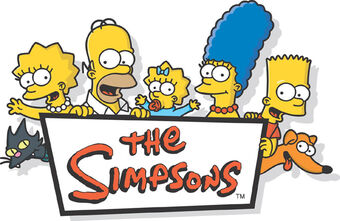

In [3]:
from IPython.display import Image
Image(filename='Simpsons-logo-1-.jpg')

### About the dataset 

This dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989. It can be found here: https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data (~25MB)

In [4]:
data = pd.read_csv('simpsons_dataset.csv')
data.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


raw_character_text: the character who speaks (can be useful when monitoring the preprocessing steps)

spoken_words: the raw text from the line of dialogue

In [5]:
data.shape

(158314, 2)

In [6]:
#Checking the nulls in both the columns
data.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [7]:
#Removing the missing values
data = data.dropna().reset_index(drop=True)
data.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

### Preprocessing

One of the traditional way to clean a text data is to remove the stop words and perform either lemmatizion or stemming to find the root/base words of the words present. This in turn reduces the dimensions of the vector space

In [8]:
#Creates a spacy object
nlp = spacy.load('en', disable=['ner', 'parser'])

def cleaning(doc):
    # Lemmatizes and removes stopwords and make sure doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

#### Removes the non-alphabetic characters

In [9]:
#Creating a generator for the spacy pipeline
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['spoken_words'])

#### Let us use SpaCy's pipe() which process texts as a stream and yield Doc objects in order. This is usually more efficient than processing texts one-by-one.

In [10]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.18 mins


In [11]:
data_clean = pd.DataFrame({'clean': txt})
data_clean = data_clean.dropna().drop_duplicates()
data_clean.shape

(85954, 1)

In [12]:
data_clean.head()

,clean
0,actually little disease magazine news show nat...
2,know sure like talk touch lesson plan teach
3,life worth live
4,poll open end recess case decide thought final...
7,victory party slide


### Bigrams

People read texts. The texts consist of sentences and also sentences consist of words. Human beings can understand linguistic structures and their meanings easily, but machines are not successful enough on natural language comprehension yet. So, we try to teach some languages to machines like we do for an elementary school kid. We add two words at a time and this is called Bigrams

In gensim, each sentence is regarded as a document and collection of documents is a corpus. A corpora serves as a input to a model. In gensim a model is treated as an abstract term referring to a transformation from one document representation to another. In gensim documents are represented as vectors so a model can be thought of as a transformation between two vector spaces.

In [13]:
#Phrases() takes list of list of words as input
sent = [row.split() for row in data_clean['clean']]

In [14]:
print(sent[0:10])

[['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think'], ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'], ['life', 'worth', 'live'], ['poll', 'open', 'end', 'recess', 'case', 'decide', 'thought', 'final', 'statement', 'martin'], ['victory', 'party', 'slide'], ['mr', 'bergstrom', 'mr', 'bergstrom'], ['hey', 'hey', 'move', 'morning', 'new', 'job', 'take', 'copernicus', 'costume'], ['think', 'take', 'train', 'capital', 'city'], ['train', 'like', 'traditional', 'environmentally', 'sound'], ['yes', 'backbone', 'country', 'leland', 'stanford', 'drive', 'golden', 'spike', 'promontory', 'point']]


Phrases() Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

In [15]:
#Training the sent on phrase model
phrases = Phrases(sent, threshold=1,min_count=30,scoring="npmi", progress_per=10000)

INFO - 19:39:51: collecting all words and their counts
INFO - 19:39:51: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:39:51: PROGRESS: at sentence #10000, processed 63557 words and 52796 word types
INFO - 19:39:51: PROGRESS: at sentence #20000, processed 130938 words and 99801 word types
INFO - 19:39:51: PROGRESS: at sentence #30000, processed 192959 words and 138413 word types
INFO - 19:39:51: PROGRESS: at sentence #40000, processed 249832 words and 172509 word types
INFO - 19:39:51: PROGRESS: at sentence #50000, processed 311271 words and 208406 word types
INFO - 19:39:51: PROGRESS: at sentence #60000, processed 373576 words and 243519 word types
INFO - 19:39:51: PROGRESS: at sentence #70000, processed 436427 words and 278547 word types
INFO - 19:39:52: PROGRESS: at sentence #80000, processed 497891 words and 311704 word types
INFO - 19:39:52: collected 330480 word types from a corpus of 537095 words (unigram + bigrams) and 85954 sentences
INFO - 19:39:52: us

**The scoring="npmi" is more robust when dealing with common words that form part of common bigrams, and ranges from -1 to 1, but is slower to calculate than the default scoring="default".**

In [16]:
#Transform the corpus based on the bigrams detected by using the phrases model which we just created/
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 19:39:52: source_vocab length 330480
INFO - 19:39:54: Phraser built with 0 phrasegrams


In [17]:
#Count frequencies
frequency = defaultdict(int)
for text in sentences:
    for i in text:
        frequency[i] +=1
len(frequency)      

30128

In [18]:
sorted(frequency,key=frequency.get, reverse=True)[:10]

['oh', 'like', 'go', 'get', 'know', 'hey', "'", 'think', 'come', 'right']

## Training  the model

### Gensim Word2Vec Implementation

1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [19]:
# Count the number of cores in a computer
cores = multiprocessing.cpu_count()

## Word2Vec Model

### The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model in terms of your final results. The settings here probably has more of an effect on memory usage and storage requirements of the model files. - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. If your neighbor’s position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related. Again, if your data is not sparse, then the window size should not matter too much, as long as it’s not overly narrow or overly broad. If you are not too sure about this, just use the default value. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors.(i.e. the context or neighboring words).If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, it’s good to experiment with various sizes. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [20]:
#We aren't supplying any list of lists of token to the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

_Parameters of the training:_
* `corpus_iterable` <font color='purple'>=</font> <font color='green'>iterable of list of str</font> - Can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network.;

In [21]:
#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:39:56: collecting all words and their counts
INFO - 19:39:56: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:39:56: PROGRESS: at sentence #10000, processed 63557 words, keeping 9472 word types
INFO - 19:39:56: PROGRESS: at sentence #20000, processed 130938 words, keeping 14430 word types
INFO - 19:39:56: PROGRESS: at sentence #30000, processed 192959 words, keeping 17552 word types
INFO - 19:39:56: PROGRESS: at sentence #40000, processed 249832 words, keeping 20314 word types
INFO - 19:39:56: PROGRESS: at sentence #50000, processed 311271 words, keeping 22822 word types
INFO - 19:39:57: PROGRESS: at sentence #60000, processed 373576 words, keeping 25132 word types
INFO - 19:39:57: PROGRESS: at sentence #70000, processed 436427 words, keeping 27353 word types
INFO - 19:39:57: PROGRESS: at sentence #80000, processed 497891 words, keeping 29236 word types
INFO - 19:39:57: collected 30128 word types from a corpus of 537095 raw words and 85954 sentence

Time to build vocab: 0.03 mins


The steps above, builds the vocabulary, and starts training the **Word2Vec model**. Behind the scenes, what’s happening here is that we are training a neural network with a single hidden layer where we train the model to predict the current word based on the context (using the default neural architecture). However, we are not going to use the neural network after training! 

Instead, the goal is to learn the weights of the hidden layer with the believe that the these weights encode the meaning of words in the vocabulary. These weights are essentially the word vectors that we’re trying to learn. The resulting learned vector is also known as the **embeddings**.You can think of these embeddings as some features that describe the target word. Think of the this process as extracting a table of weights for each word in the vocabulary. Where each row encodes some meaning information for the word 


 For example, the word `king` may be described by the gender, age, the type of people the king associates with, etc.

## Training the model

_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [22]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 19:39:57: training model with 11 workers on 3218 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 19:39:59: EPOCH 1 - PROGRESS: at 65.39% examples, 128734 words/s, in_qsize 0, out_qsize 0
INFO - 19:39:59: worker thread finished; awaiting finish of 10 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 9 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 8 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 7 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 6 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 5 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 4 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 3 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 2 more threads
INFO - 19:39:59: worker thread finished; awaiting finish of 1 more threads
INFO - 19:39:59: 

INFO - 19:40:10: worker thread finished; awaiting finish of 1 more threads
INFO - 19:40:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:10: EPOCH - 8 : training on 537095 raw words (198029 effective words) took 1.4s, 138466 effective words/s
INFO - 19:40:11: EPOCH 9 - PROGRESS: at 65.39% examples, 127059 words/s, in_qsize 0, out_qsize 1
INFO - 19:40:11: worker thread finished; awaiting finish of 10 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 9 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 8 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 7 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 6 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 5 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 4 more threads
INFO - 19:40:11: worker thread finished; awaiting finish of 3 more threads
INFO - 19:40:11: worker thread fi

INFO - 19:40:22: worker thread finished; awaiting finish of 3 more threads
INFO - 19:40:22: worker thread finished; awaiting finish of 2 more threads
INFO - 19:40:22: worker thread finished; awaiting finish of 1 more threads
INFO - 19:40:22: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:22: EPOCH - 16 : training on 537095 raw words (198310 effective words) took 1.5s, 133825 effective words/s
INFO - 19:40:23: EPOCH 17 - PROGRESS: at 63.53% examples, 124315 words/s, in_qsize 0, out_qsize 0
INFO - 19:40:23: worker thread finished; awaiting finish of 10 more threads
INFO - 19:40:23: worker thread finished; awaiting finish of 9 more threads
INFO - 19:40:23: worker thread finished; awaiting finish of 8 more threads
INFO - 19:40:23: worker thread finished; awaiting finish of 7 more threads
INFO - 19:40:23: worker thread finished; awaiting finish of 6 more threads
INFO - 19:40:23: worker thread finished; awaiting finish of 5 more threads
INFO - 19:40:23: worker thread 

INFO - 19:40:34: worker thread finished; awaiting finish of 5 more threads
INFO - 19:40:34: worker thread finished; awaiting finish of 4 more threads
INFO - 19:40:34: worker thread finished; awaiting finish of 3 more threads
INFO - 19:40:34: worker thread finished; awaiting finish of 2 more threads
INFO - 19:40:34: worker thread finished; awaiting finish of 1 more threads
INFO - 19:40:34: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:34: EPOCH - 24 : training on 537095 raw words (198349 effective words) took 1.4s, 138425 effective words/s
INFO - 19:40:35: EPOCH 25 - PROGRESS: at 63.53% examples, 122526 words/s, in_qsize 0, out_qsize 1
INFO - 19:40:35: worker thread finished; awaiting finish of 10 more threads
INFO - 19:40:35: worker thread finished; awaiting finish of 9 more threads
INFO - 19:40:35: worker thread finished; awaiting finish of 8 more threads
INFO - 19:40:35: worker thread finished; awaiting finish of 7 more threads
INFO - 19:40:35: worker thread 

Time to train the model: 0.76 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [23]:
w2v_model.init_sims(replace=True)

INFO - 19:40:43: precomputing L2-norms of word weight vectors


## Exploring the model

All we need to do here is to call the most_similar function and provide the word as the positive example. This returns the top 10 similar words.

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/02/Homer_Simpson_2006.png/revision/latest?cb=20091207194310" alt="drawing" width="130"/>

Let's see what we get for the show's main character:

In [24]:
w2v_model.wv.most_similar(positive=["homer"])

[('eliza', 0.6718552112579346),
 ('refund', 0.6702365875244141),
 ('marge', 0.6508219242095947),
 ('simpson', 0.6456893682479858),
 ('abe', 0.6415181756019592),
 ('fault', 0.6285484433174133),
 ('ralphie', 0.6214817762374878),
 ('glamorous', 0.6212166547775269),
 ('care', 0.6176233291625977),
 ('listen', 0.6118557453155518)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [25]:
w2v_model.wv.most_similar(positive=["homer"])

[('eliza', 0.6718552112579346),
 ('refund', 0.6702365875244141),
 ('marge', 0.6508219242095947),
 ('simpson', 0.6456893682479858),
 ('abe', 0.6415181756019592),
 ('fault', 0.6285484433174133),
 ('ralphie', 0.6214817762374878),
 ('glamorous', 0.6212166547775269),
 ('care', 0.6176233291625977),
 ('listen', 0.6118557453155518)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>

What about Marge now?

In [26]:
w2v_model.wv.most_similar(positive=["marge"])

[('hopeless', 0.7332247495651245),
 ('homie', 0.730643630027771),
 ('sure', 0.7221070528030396),
 ('grownup', 0.713304340839386),
 ('snuggle', 0.7107611894607544),
 ('becky', 0.7099272608757019),
 ('raccoon', 0.7037234306335449),
 ('spoil', 0.6922976970672607),
 ('ease', 0.6825999021530151),
 ('umm', 0.6775256991386414)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="100"/>

Let's check Bart now:

In [27]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8382601141929626),
 ('badly', 0.7613170146942139),
 ('hearing', 0.7408995032310486),
 ('substitute', 0.7386535406112671),
 ('embarrassing', 0.724885880947113),
 ('strangle', 0.721714198589325),
 ('eliza', 0.721295177936554),
 ('childhood', 0.7061626315116882),
 ('mom', 0.6957359313964844),
 ('convince', 0.694033145904541)]

### Similarity between two words

Under the hood, the below three snippets compute the cosine similarity between the two specified words using word vectors (embeddings) of each.If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity can go from [-1 to 1] and sometimes bounded between [0,1] depending on how it’s being computed

In [28]:
w2v_model.wv.similarity(w1='marriage',w2='marge')

0.6016025

In [30]:
w2v_model.wv.similarity(w1='current',w2='homer')

0.46214664

In [31]:
w2v_model.wv.similarity(w1="ralphie", w2='threat')

0.3741593

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [32]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 19:42:52: vectors for words {'kearney'} are not present in the model, ignoring these words
C:\Users\avina\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

In [33]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'bart'

In [34]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

Damn, they really do not like you Homer!

## Analogy difference:
Which word is to woman as homer is to marge?

In [35]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('young', 0.634882926940918),
 ('man', 0.5731571912765503),
 ('wealthy', 0.5658777356147766)]

In [39]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.7142570614814758),
 ('pregnant', 0.6825162172317505),
 ('surprised', 0.674880862236023)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in **red**), its most similar words in the model (in **blue**), and other words from the vocabulary (in **green**).

In [41]:
#Shamelessly copied from the kaggle kernel
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## 10 most similar words vs 8 random words

Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

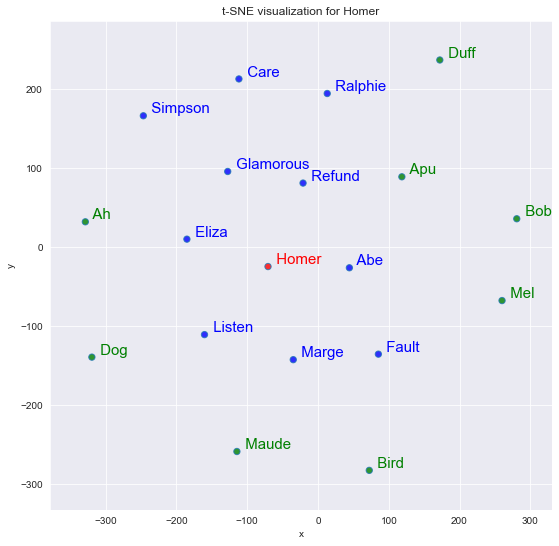

In [42]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

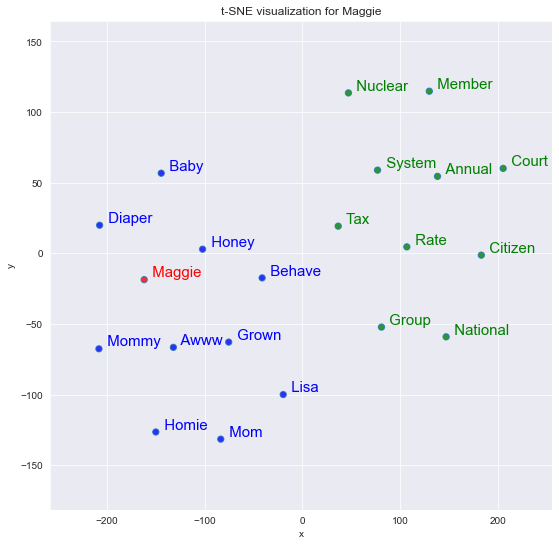

In [43]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to bart ranked 1st to 10th versus the ones ranked 11th to 20th:

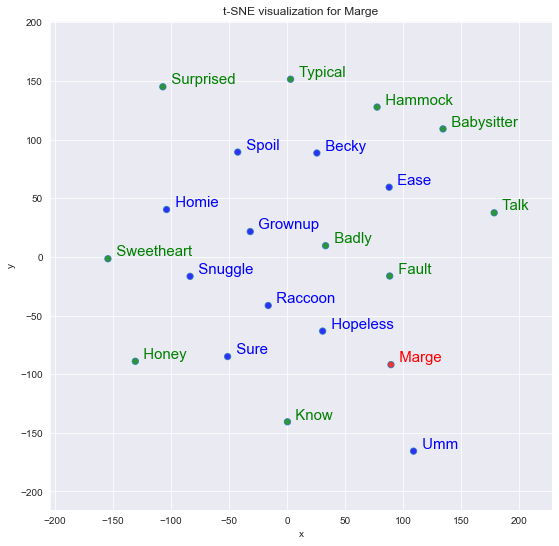

In [47]:
tsnescatterplot(w2v_model, "marge", [t[0] for t in w2v_model.wv.most_similar(positive=["marge"], topn=20)][10:])